In [22]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = os.path.join(".","data","cs-train")

In [23]:
def makeHistogram(dataframe, column_name, label_name, UL, bin_number):
    f, ax = plt.subplots(figsize=(9, 4))
    plt.hist(dataframe[column_name], bins = bin_number, label = label_name)
    plt.xlim(0,UL)
    plt.legend(loc='upper right')
    
def fixOutliers(data, colname): 
    std = data[colname].std()
    mean = data[colname].mean()
    ul = mean + 3*std 
    ll = mean - 3*std
    if ll < 0: ll = 0 # only positive values
    return data.drop(set(data[(data[colname] > ul)|(data[colname] <= ll)].index))

In [24]:
df = pd.DataFrame()

dataset_names = sorted([f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))])
print("The following ", len(dataset_names), " dataframes will be used for training:\n")

for name in dataset_names:
    print(name)
    path = os.path.join(DATA_DIR, name)
    df_name = pd.read_json(path)
    df = df.append(df_name)

# df = df.rename(columns={'total_price': 'Total_Price','StreamID': 'Stream_Id', 'TimesViewed': 'Times_Viewed'})
 

The following  21  dataframes will be used for training:

invoices-2017-11.json
invoices-2017-12.json
invoices-2018-01.json
invoices-2018-02.json
invoices-2018-03.json
invoices-2018-04.json
invoices-2018-05.json
invoices-2018-06.json
invoices-2018-07.json
invoices-2018-08.json
invoices-2018-09.json
invoices-2018-10.json
invoices-2018-11.json
invoices-2018-12.json
invoices-2019-01.json
invoices-2019-02.json
invoices-2019-03.json
invoices-2019-04.json
invoices-2019-05.json
invoices-2019-06.json
invoices-2019-07.json


In [25]:
df.head(3)

,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,total_price,StreamID,TimesViewed
0,United Kingdom,13085.0,489434,6.95,85048,12.0,2017,11,28,NaN,NaN,NaN
1,United Kingdom,NaN,489597,8.65,22130,1.0,2017,11,28,NaN,NaN,NaN
2,United Kingdom,NaN,489597,1.70,22132,6.0,2017,11,28,NaN,NaN,NaN


In [26]:
df["date"] = pd.to_datetime(df.year*10000+df.month*100+df.day, format='%Y%m%d')
df = df.drop(columns=['year', 'month', 'day'])
df.head(3)

,country,customer_id,invoice,price,stream_id,times_viewed,total_price,StreamID,TimesViewed,date
0,United Kingdom,13085.0,489434,6.95,85048,12.0,NaN,NaN,NaN,2017-11-28
1,United Kingdom,NaN,489597,8.65,22130,1.0,NaN,NaN,NaN,2017-11-28
2,United Kingdom,NaN,489597,1.70,22132,6.0,NaN,NaN,NaN,2017-11-28


In [27]:
df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
df['invoice'].value_counts()

537434    1350
538071    1304
537638    1202
537237    1194
536876    1186
          ... 
502652       1
543663       1
495219       1
559677       1
498920       1
Name: invoice, Length: 42646, dtype: int64

In [28]:
df.describe()

,customer_id,price,times_viewed,total_price,TimesViewed
count,625249.000000,654316.000000,292297.000000,160695.000000,522714.000000
mean,15333.415068,4.615812,5.213269,5.563319,5.241080
std,1698.360788,137.830821,5.111288,123.125964,5.109229
min,12346.000000,-53594.360000,0.000000,0.000000,0.000000
25%,13956.000000,1.250000,1.000000,1.250000,1.000000
50%,15279.000000,2.100000,3.000000,2.510000,3.000000
75%,16813.000000,4.150000,8.000000,4.250000,8.000000
max,18287.000000,38970.000000,24.000000,16888.020000,24.000000


In [29]:
# Remove outliers
df = df[df['price'].between(df['price'].quantile(0.01), df['price'].quantile(0.99))]
#df=fixOutliers(df, 'price')

In [30]:
df.describe()

,customer_id,price,times_viewed,total_price,TimesViewed
count,514692.000000,641507.000000,213000.000000,0.0,428507.000000
mean,15333.331064,3.213593,5.389352,NaN,5.398535
std,1692.454852,3.063650,5.156441,NaN,5.149826
min,12346.000000,0.210000,0.000000,NaN,0.000000
25%,13957.000000,1.250000,1.000000,NaN,1.000000
50%,15271.000000,2.100000,3.000000,NaN,3.000000
75%,16801.000000,4.130000,9.000000,NaN,9.000000
max,18287.000000,19.950000,24.000000,NaN,24.000000


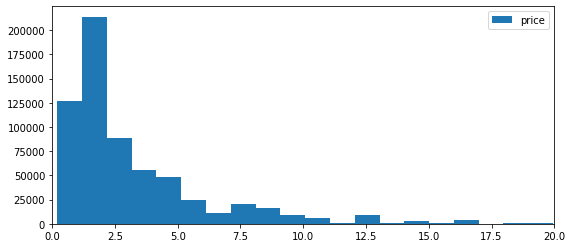

In [31]:
makeHistogram(df, 'price', 'price', 20, 20)

In [32]:
columns_to_show =['price']
pd.pivot_table(df, index = ['country'], values=columns_to_show, aggfunc='sum').sort_values('price', ascending=False).head(10).round(1)

,price
country,
United Kingdom,1898994.6
EIRE,39624.1
Germany,34758.4
France,24395.7
Netherlands,8490.6
Belgium,6554.3
Switzerland,6182.9
Spain,4859.2
Channel Islands,4291.4


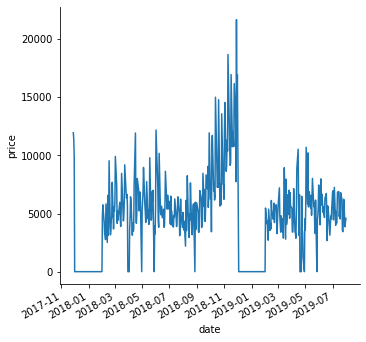

In [33]:
g = sns.relplot(x='date', y='price', data=df.groupby(pd.Grouper(key='date', freq='B')).sum().reset_index(), kind='line')
g.fig.autofmt_xdate()